In [1]:
# script that creates plots for tissue-specific disease analyses

import config
from ccsblib import paros_connection
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

connect = paros_connection()
cursor = connect.cursor()

figure_path = '../figures/'
db_table = 'hi2018_paper.OMIM_disease_tissue'

def expression_heatmap(axes, gtex, gene_names, vmax=8.):
    ensembl_ids = [tup[0] for tup in gene_names]
    symbols = [tup[1] for tup in gene_names]
    data = gtex.loc[ensembl_ids, :]
    ax = axes[0]
    cax = ax.imshow(data.T.values,
                    vmin=-8.,
                    vmax=vmax,
                    cmap='seismic')
    ax.set_xticks(range(data.shape[0]))
    ax.set_xticklabels(symbols, rotation=45, ha='left')
    ax.xaxis.tick_top()
    ax.set_yticks([])
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    axes[0].set_yticks(range(data.shape[1]))
    axes[0].yaxis.set_tick_params(length=0)
    axes[0].xaxis.set_tick_params(length=0)
    axes[0].set_yticklabels(data.columns, rotation=0)
    axes[-1].set_axis_off()
    ax.set_ylim(-0.5, data.shape[1] - 0.5)
    ax.invert_yaxis()
    plt.colorbar(cax,
                 ax=axes[-1],
                 ticks=[-8., -6, -4., -2., 0., 2., 4., 6, 8.],
                 label='Tissue-preferential expression value',
                 fraction=0.7)


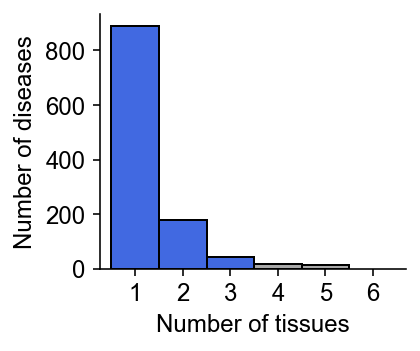

In [2]:
# plot a histogram for the number of diseases that are assigned to a given number of tissues
query = """select a.omim_id,count(*) num_tissues from 
            (select distinct omim_id,tissue_category  
            from {}
            where gene_type='protein_coding' and tissue_category!='testis' and tissue_expr_value>5) as a 
            group by a.omim_id""".format(db_table)
cursor.execute(query)
num_tissues = [int(row[1]) for row in cursor]
num_tissues_gr = list(filter(lambda v: v >= 4,num_tissues))
num_tissues_sm = list(filter(lambda v: v <= 3,num_tissues))
plt.figure(figsize=(3,2.5))
plt.hist(num_tissues,bins=range(1,7),edgecolor='black',color='darkgrey')
plt.hist(num_tissues_sm,bins=range(1,5),edgecolor='black',color='royalblue')
plt.xlabel('Number of tissues',fontsize=12)
plt.ylabel('Number of diseases',fontsize=12)
plt.xticks([i+0.5 for i in range(1,7)],range(1,7),fontsize=12)
plt.xlim(xmax=7.2)
plt.yticks(fontsize=12)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
outfile = figure_path + 'num_diseases_num_tissue_types_distr_split'
plt.savefig(outfile + '.pdf',format='pdf',dpi=300)
plt.savefig(outfile + '.png',format='png',dpi=300)
plt.show()

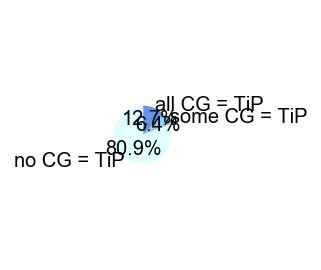

In [3]:
# plot the split of the diseases by CGs being TiP genes and draw as pie chart
query = """select distinct omim_id
        from {} 
        where number_tissues<=3 and gene_type='protein_coding' and 
            disease_tissue!='testis' and tissue_expr_value>5""".format(db_table)
cursor.execute(query)
rows = cursor.fetchall()
num_diseases = len(rows)

# get the number of diseases that have at least 1 causal gene that is not a TiP gene in one of the disease tissues
query = """select distinct omim_id
        from {}
        where number_tissues<=3 and gene_type='protein_coding' and tissue_expr_value>5 and 
        tissue_TiP_value<2 and disease_tissue!='testis'""".format(db_table)
cursor.execute(query)
rows = cursor.fetchall()
num_dis_ge_1CG_not_TiP = len(rows)

# get the number of diseases that don't have a single causal gene that is a TiP gene in one of the disease tissues
query = """select distinct a.omim_id 
        from (select * 
            from {} where number_tissues<=3 and gene_type='protein_coding' and 
                tissue_expr_value>5 and disease_tissue!='testis') as a 
        where a.omim_id not in
            (select distinct omim_id
            from {}
            where number_tissues<=3 and gene_type='protein_coding' and tissue_expr_value>5 and 
                tissue_TiP_value>=2 and disease_tissue!='testis')""".format(db_table,db_table)
cursor.execute(query)
rows = cursor.fetchall()
num_dis_noCG_is_TiP = len(rows)


labels = ['all CG = TiP','some CG = TiP','no CG = TiP']
sizes = [num_diseases-num_dis_ge_1CG_not_TiP,num_dis_ge_1CG_not_TiP-num_dis_noCG_is_TiP,num_dis_noCG_is_TiP]
explode = [0,0,0]
colors = ['cornflowerblue','lightskyblue','lightcyan']

plt.figure(figsize=(2,2))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', colors=colors, shadow=False, startangle=90, counterclock=False)
ax1 = plt.gca()
ax1.axis('equal')

plt.tight_layout()
outfile = figure_path + 'num_diseases_CG_TiP_counts_pie_chart'
plt.savefig(outfile + '.pdf',format='pdf',dpi=300)
plt.savefig(outfile + '.png',format='png',dpi=300)

plt.show()

In [4]:
# generate heatmaps for all causal genes and their interaction partners but only plot TiP values for the affected tissues
file1 = open(config.data_path + 'GTExv6_JPnorm_subtypes_no_cell_publ.txt','r')
entries = file1.readlines()
file1.close()
publ_tissues = [line[:-1] for line in entries]
publ_tissues.remove('Testis')

qry = """select a.ensembl_gene_id ensembl_gene_id_complete,b.* from hi2018_paper.protein_coding_genome a
        left join
        hi2018_paper.GTEx_TiP_no_testis_PC_matrix b
        using (ensembl_gene_id);"""
gtex = pandas.read_sql(qry, connect)
gtex = gtex.drop(columns=['ensembl_gene_id'])
gtex = gtex.rename(columns={'ensembl_gene_id_complete':'ensembl_gene_id'})
gtex = gtex.set_index('ensembl_gene_id')
tissue_name_dict = dict(zip(gtex.columns.tolist(),publ_tissues))
gtex = gtex.rename(columns=tissue_name_dict)
gtex = gtex.fillna(0)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-2230f4f869e9>", line 12, in <module>
    gtex = pandas.read_sql(qry, connect)
  File "/usr/local/lib/python3.7/site-packages/pandas/io/sql.py", line 410, in read_sql
    chunksize=chunksize,
  File "/usr/local/lib/python3.7/site-packages/pandas/io/sql.py", line 1645, in read_query
    cursor = self.execute(*args)
  File "/usr/local/lib/python3.7/site-packages/pandas/io/sql.py", line 1595, in execute
    cur.execute(*args)
  File "/usr/local/lib/python3.7/site-packages/pymysql/cursors.py", line 170, in execute
    result = self._query(query)
  File "/usr/local/lib/python3.7/site-packages/pymysql/cursors.py", line 328, in _query
    conn.query(q)
  File "/usr/local/lib/python3.7/site-packages/pymysql/connections.py", line 517, in query
    self._affected_rows = self._read_

KeyboardInterrupt: 

In [ ]:
query = """select distinct causal_gene_id,CG_symbol 
        from hi2018_paper.edgotyping 
        where GS_WT > 1"""
cursor.execute(query)
CG_symbols = [(row[0],row[1]) for row in cursor]

for CG in CG_symbols:
    print(CG)
    gene_id = CG[0]
    CG_symbol = CG[1]
    # get all disease tissues for the diseases for the causal alleles that were tested
    query = """select distinct omim_ids 
            from hi2018_paper.edgotyping 
            where (pathogenecity like "%athogen%" or pathogenecity="risk factor") and 
                   CG_symbol='{}'""".format(CG_symbol)
    cursor.execute(query)
    rows = cursor.fetchall()
    omim_ids = []
    for row in rows:
        omim_ids = omim_ids + row[0].split('|')
    omim_ids = list(set(omim_ids))
    if len(omim_ids) > 0:
        query = """select distinct disease_tissue 
                from hi2018_paper.OMIM_disease_tissue 
                where ensembl_gene_id='{}' and omim_id in ({})""".format(gene_id,','.join([str(o) for o in omim_ids]))
        cursor.execute(query)
        sel_tissues = sorted([tissue_name_dict[row[0]] for row in cursor])
        query = """select distinct interactor_gene_id,interactor_symbol 
                from hi2018_paper.edgotyping 
                where CG_symbol='{}'
                and GS_WT > 1
                and interactor_tis_expr > 5
                order by interactor_symbol""".format(CG_symbol)
        cursor.execute(query)
        interactors = [CG] + [(row[0],row[1].upper()) for row in cursor]
        fig, axes = plt.subplots(1, 2, sharey=True)
        fig.set_size_inches(13., 10.)
        sub_gtex = gtex[sel_tissues]
        expression_heatmap(axes, 
                           sub_gtex, 
                           interactors,
                           vmax=8.)
        plt.tight_layout()
        outfile = figure_path + 'TiP_expr_heatmap_dis_tissues' + CG_symbol
        plt.savefig(outfile + '.pdf', bbox_inches='tight')
        plt.savefig(outfile + '.png', bbox_inches='tight', dpi=300)
        plt.show()